<a href="https://colab.research.google.com/github/alexander-n-thomas/spark-nlp-book-prod/blob/master/2_10_Topic_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os

# Install java
! apt-get install -y openjdk-8-jdk-headless -qq > /dev/null
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]
! java -version

# Install pyspark
! pip install --ignore-installed pyspark==2.4.4

# Install Spark NLP
! pip install --ignore-installed spark-nlp==2.5.1

openjdk version "1.8.0_252"
OpenJDK Runtime Environment (build 1.8.0_252-8u252-b09-1~18.04-b09)
OpenJDK 64-Bit Server VM (build 25.252-b09, mixed mode)
     |████████████████████████████████| 215.7MB 54kB/s 
     |████████████████████████████████| 204kB 37.6MB/s 
  Created wheel for pyspark: filename=pyspark-2.4.4-py2.py3-none-any.whl size=216130388 sha256=58b9d84b7025097456a2d3a73c3f28d8c430cda7bd6c68248ccd03039ff48e54
  Stored in directory: /root/.cache/pip/wheels/ab/09/4d/0d184230058e654eb1b04467dbc1292f00eaa186544604b471
Successfully built pyspark
     |████████████████████████████████| 122kB 2.7MB/s 


In [2]:
import nltk

nltk.download('brown')
nltk.download('stopwords')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [59]:
! mkdir -p data

In [60]:
! wget https://archive.ics.uci.edu/ml/machine-learning-databases/20newsgroups-mld/mini_newsgroups.tar.gz

--2020-07-24 04:45:28--  https://archive.ics.uci.edu/ml/machine-learning-databases/20newsgroups-mld/mini_newsgroups.tar.gz
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1860687 (1.8M) [application/x-httpd-php]
Saving to: ‘mini_newsgroups.tar.gz’

mini_newsgroups.tar 100%[===================>]   1.77M  4.08MB/s    in 0.4s    

2020-07-24 04:45:28 (4.08 MB/s) - ‘mini_newsgroups.tar.gz’ saved [1860687/1860687]



In [61]:
! tar xzf mini_newsgroups.tar.gz -C ./data/

# Topic Modeling

In the previous chapter we covered some of the techniques used to extract information from text. These techniques can be complicated to implement and may also be slow. If the application requires the information extracted to be readable by the users, these techniques are great. If we are looking to extract information as part of an intermediate processing step—for instance, building features for a classifier—then we don't need to extract readable information. As we saw in Chapters #processing_words and #classification_and_regression, simply using our vocabulary will create an unwieldy number of features. Therefore, we want to reduce the dimensionality of our data. This is where distributional semantics comes in.

Distributional semantics is the study, using statistical distributions, of elements of language to characterize similarities between documents (e.g., email), speech acts (e.g., spoken or written sentences), or elements thereof (e.g., phrases, words).  The idea for this field comes from John R. Firth, a linguist in the first half of the 20th century.  He noted how semantics was dependent on context and coined the oft-repeated quote, "You shall know a word by the company it keeps."

The idea is that you can represent a word as a probabilistic distribution over the contexts it appears in. The words will exist in a vector space where the dimensions are associated with these contexts. For example, "doctor" will have a larger value on the medical dimension than in the financial dimension. However, "bank" will have larger values on the financial dimension and the geological dimension. We can't simply use hand-chosen contexts, though. These too must be learned from the data. Commonly, we learn the contexts by looking at what words occur with each other. This back-and-forth means that most such algorithms iterate until they find the model that best fits the data. These approaches are a kind of clustering. Indeed, we can use more generic clustering algorithms on text data, though they may not work well.

In the following examples, we have a document-term matrix in which the rows are documents, and columns are terms. The values can be binary, representing word presence, or the number of times a term occurs, or they can be TF.IDF values. We will be using TF.IDF values in this chapter. Once we have such a matrix, we will want to map our documents to a space with fewer dimensions. This clusters the documents into topics.

We will be using the Python library scikit-learn to introduce the techniques. This library will allow us to more easily examine the internal data of these models than would Spark's implementation.

## K-Means

As a first attempt at topic modeling, let's try a classic clustering technique—K-Means, as shown in kmeans. Let's say we have a number of data points in a vector space. We can pick K points in the vector space, called centroids, and assign each data point to the closest centroid. We want to find the K points that minimize the distance between the data points and their centroid.

![Simple visualization of K-Means](https://i.imgur.com/6mTEteL.png)  
_Simple visualization of K-Means_

In our situation, we have documents in a vector space defined by the TF.IDF values. When we find our `K` points, we can say that each `K` represents a topic. Let's look at an example.

First, let's build our data set. We will be using the Brown corpus, which is a collection of articles, periodicals, and reports from newspapers, journals, and academic institutions. It is a classic data set that has been used in NLP since the 1960s.

In [3]:
from collections import defaultdict, Counter, OrderedDict

import numpy as np
import pandas as pd
import scipy.sparse as sparse

from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

from nltk.corpus import stopwords
from nltk.corpus import brown
en_stopwords = set(stopwords.words('english'))

In [4]:
def detokenize(sentence):
    text = ''
    for token in sentence:
        if text and any(c.isalnum() for c in token):
            text += ' '
        text += token
    return text

We will want to remove the punctuation and the stop words so our algorithms use only the "useful" words.

In [5]:
def process(sentence):
    terms = []
    for term in sentence:
        term = term.lower()
        if term not in en_stopwords and term.isalnum():
            terms.append(term)
    return terms

Let's gather our docs. Our documents will be lists of lists of terms.

In [6]:
docs = OrderedDict()

for fid in brown.fileids():
    docs[fid] = brown.sents(fid)

Now we will construct indices. This is similar to what we did when we were exploring information retrieval.

In [7]:
ix2doc = list(docs)
doc2ix = {fid: i for i, fid in enumerate(ix2doc)}
vocabulary = set()

term_counts = defaultdict(Counter)
document_counts = Counter()

for fid, doc in docs.items():
    unique_terms = set()
    for sentence in doc:
        sentence = process(sentence)
        term_counts[fid].update(sentence)
        unique_terms.update(sentence)
    document_counts.update(unique_terms)
    vocabulary.update(unique_terms)

ix2term = sorted(list(vocabulary))
term2ix = OrderedDict()
for i, term in enumerate(ix2term):
    term2ix[term] = i

Now that we have our indices, let's construct a matrix for TF and IDF.

In [8]:
term_count_mat = sparse.dok_matrix((len(doc2ix), len(term2ix)))

for fid, i in doc2ix.items():
    for term, count in term_counts[fid].items():
        j = term2ix[term]
        term_count_mat[i, j] = count
term_count_mat = term_count_mat.todense()

doc_count_vec = np.array(
    [document_counts[term] for term in term2ix.keys()])

In [9]:
tf = np.log(term_count_mat + 1)
idf = len(doc2ix) / (1 + doc_count_vec)

tfidf = np.multiply(tf, idf)

In [10]:
tfidf.shape

(500, 40881)

This is a rather large matrix for such a small data set. Apart from space efficiency concerns, having this many dimensions can worsen performance for some algorithms. This is when distributional semantics can help.

Now, we can build our model.

In [11]:
from sklearn.cluster import KMeans

In [12]:
K = 6
clusters = ['cluster#{}'.format(k) for k in range(K)]
model = KMeans(n_clusters=K, random_state=314)

In [13]:
clustered = model.fit_transform(tfidf)

In [14]:
clustered.shape

(500, 6)

We can see that we have now clustered our documents using our six centroids. Each of these centroids is a vector over our vocabulary. We can look at which words are most influential on our centroids. We will use word clouds for this.

In [15]:
model.cluster_centers_.shape

(6, 40881)

In [16]:
cluster_term = pd.DataFrame(
    model.cluster_centers_.T, index=ix2term, columns=clusters)
cluster_term = np.round(cluster_term, decimals=4)

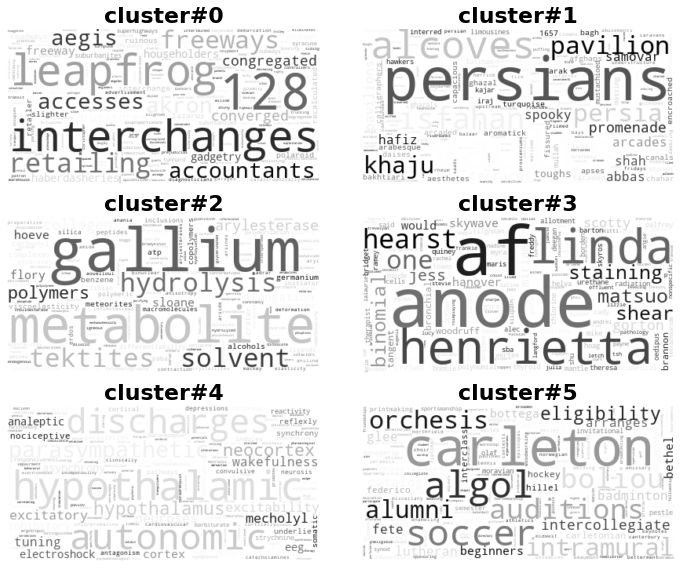

In [17]:
font = {'weight' : 'bold', 'size'   : 22}
fig, axs = plt.subplots(K // 2, 2, figsize=(10, 8))

k = 0
for i in range(len(axs)):
    for j in range(len(axs[i])):
        wc = WordCloud(colormap='Greys', background_color='white')
        im = wc.generate_from_frequencies(cluster_term[clusters[k]])
        axs[i][j].imshow(im, interpolation='bilinear')
        axs[i][j].axis("off")
        axs[i][j].set_title(clusters[k], **font)
        k += 1
        
plt.tight_layout()
plt.show()

We can see some recognizable topics here. Cluster #5 seems to be about mathematical topics. Cluster #3 seems to be about food preparation, specifically pasteurization.

K-Means does not make many assumptions about our data—it just tries to find the K. One drawback to K-Means is that it tends to create equally sized clusters. This is an unrealistic expectation for a natural corpus. Additionally, we don't get much in the way if characterizing the similarity between documents. Let's try an algorithm that makes some more assumptions but that will give us a way to see the similarities between these documents.

## Latent Semantic Indexing

Latent semantic indexing (LSI) is a technique for decomposing the document-term matrix using   singular value decomposition (SVD). In SVD we decompose a matrix into three matrices.

\begin{equation}
M \rightarrow U \Sigma V^{T}
\end{equation}

Σ is a diagonal matrix of the singular values in descending order. We can take the top K, and this serves as an approximation of the original matrix. The first K columns of U are the representation of the documents in the K dimensional space. The first K columns of V are the representation of the terms in the K dimensional space. This allows us to compare the similarity of documents and terms. It is common to choose a larger number for the components because the more dimensions Σ has, the more dimensions we can use to approximate the original matrix. So we will set K to be the higher number here.

In [18]:
from sklearn.decomposition import TruncatedSVD

In [19]:
K = 100
clusters = ['cluster#{}'.format(k) for k in range(K)]
model = TruncatedSVD(n_components=K)

In [20]:
clustered = model.fit_transform(tfidf)

Let's look at the K singular values we are keeping.

In [21]:
model.singular_values_

array([3529.39940143, 3244.5123254 , 3096.10756954, 3004.86041763,
       2814.8334683 , 2779.15350335, 2754.45736204, 2714.45562879,
       2652.31070827, 2631.78997171, 2577.96112182, 2496.39904161,
       2480.48714029, 2466.880423  , 2466.04218313, 2449.80663586,
       2424.72015739, 2416.94872947, 2409.16923362, 2395.42295112,
       2378.83526756, 2373.48891216, 2344.0269895 , 2339.05289933,
       2322.58371344, 2318.34270597, 2310.7429456 , 2305.26188678,
       2301.48325318, 2294.96178429, 2293.00066881, 2286.194767  ,
       2284.68793553, 2276.46157708, 2270.05846025, 2260.8194765 ,
       2259.87049384, 2253.740432  , 2248.36504585, 2238.53151585,
       2226.04036031, 2223.50432046, 2218.08389403, 2205.96725012,
       2200.99673695, 2198.62692356, 2192.19270973, 2185.29725077,
       2177.19401693, 2166.88807538, 2162.51294105, 2156.48307909,
       2153.20830225, 2150.95456483, 2139.03195535, 2133.45213219,
       2133.19742874, 2129.76217838, 2126.10338772, 2121.40807

The `components_` of the model are the highest K diagonal values of Σ. So now, let's look at the terms distributed over the components

In [22]:
cluster_term = pd.DataFrame(model.components_.T, index=ix2term, columns=clusters)
cluster_term = np.round(cluster_term, decimals=4)

In [23]:
cluster_term.loc[['polynomial', 'cat', 'frankfurter']]

,cluster#0,cluster#1,cluster#2,cluster#3,cluster#4,cluster#5,cluster#6,cluster#7,cluster#8,cluster#9,cluster#10,cluster#11,cluster#12,cluster#13,cluster#14,cluster#15,cluster#16,cluster#17,cluster#18,cluster#19,cluster#20,cluster#21,cluster#22,cluster#23,cluster#24,cluster#25,cluster#26,cluster#27,cluster#28,cluster#29,cluster#30,cluster#31,cluster#32,cluster#33,cluster#34,cluster#35,cluster#36,cluster#37,cluster#38,cluster#39,...,cluster#60,cluster#61,cluster#62,cluster#63,cluster#64,cluster#65,cluster#66,cluster#67,cluster#68,cluster#69,cluster#70,cluster#71,cluster#72,cluster#73,cluster#74,cluster#75,cluster#76,cluster#77,cluster#78,cluster#79,cluster#80,cluster#81,cluster#82,cluster#83,cluster#84,cluster#85,cluster#86,cluster#87,cluster#88,cluster#89,cluster#90,cluster#91,cluster#92,cluster#93,cluster#94,cluster#95,cluster#96,cluster#97,cluster#98,cluster#99
polynomial,0.0003,0.0010,0.0023,0.0026,0.0053,-0.0032,-0.0003,-0.0006,-0.0042,-0.0058,0.0017,0.0015,-0.0003,-0.0057,-0.0058,0.0079,-0.0255,-0.0020,0.0060,0.0030,0.0098,0.0107,-0.0010,0.0056,-0.0040,-0.0018,0.0159,0.0060,-0.0087,-0.0113,-0.0068,0.0116,-0.0233,0.0184,0.0189,0.0290,0.0156,-0.0135,0.0085,0.0106,...,-0.0276,0.0301,-0.0540,-0.0750,0.0387,0.0308,-0.0238,-0.0568,-0.0010,-0.0221,-0.0483,0.0211,0.0039,0.0226,0.0254,-0.0219,0.0179,-0.0272,0.0251,0.0001,0.0072,0.0019,-0.0056,0.0141,-0.0119,-0.0081,0.0113,0.0057,-0.0134,0.0121,0.0019,-0.0020,-0.0039,-0.0072,-0.0050,0.0022,0.0021,-0.0024,0.0034,-0.0062
cat,0.0001,0.0018,0.0005,0.0005,0.0055,-0.0046,0.0005,0.0148,-0.0002,0.0007,-0.0018,-0.0004,0.0006,-0.0001,-0.0013,-0.0004,0.0002,-0.0006,-0.0001,-0.0019,-0.0004,-0.0013,0.0002,0.0001,0.0014,0.0013,0.0014,0.0013,-0.0015,0.0005,-0.0006,-0.0008,0.0017,-0.0008,-0.0007,0.0006,0.0002,-0.0017,-0.0004,0.0002,...,-0.0004,-0.0018,0.0042,-0.0079,0.0045,-0.0007,0.0005,-0.0006,0.0006,0.0016,0.0052,-0.0038,-0.0026,-0.0034,0.0007,0.0021,0.0045,-0.0003,0.0024,0.0003,-0.0001,0.0018,0.0061,0.0016,0.0033,-0.0083,0.0007,0.0011,-0.0011,0.0040,-0.0002,0.0003,-0.0000,-0.0003,0.0035,0.0032,-0.0012,-0.0038,0.0048,0.0033
frankfurter,0.0004,0.0018,0.0030,0.0021,0.0363,-0.0348,0.0071,-0.0217,0.0066,0.1058,0.0158,0.0295,-0.0780,-0.0145,-0.0208,-0.0122,0.0104,-0.0013,0.0013,0.0041,-0.0000,0.0018,0.0082,-0.0097,-0.0005,-0.0048,0.0044,0.0016,0.0071,0.0029,-0.0003,0.0062,-0.0002,0.0023,-0.0002,-0.0008,0.0048,-0.0038,-0.0069,0.0022,...,-0.0018,-0.0003,-0.0029,0.0007,-0.0014,-0.0016,-0.0071,-0.0028,-0.0007,0.0008,0.0027,-0.0055,0.0019,-0.0018,-0.0035,-0.0006,0.0028,0.0006,0.0013,-0.0020,-0.0037,-0.0021,0.0019,-0.0028,-0.0013,0.0032,-0.0016,0.0002,-0.0035,-0.0003,0.0015,-0.0029,0.0036,0.0047,-0.0022,0.0016,-0.0021,0.0026,-0.0017,0.0008


This table represents the distribution that the words have over each cluster.

Since we did not stem our words, let's see if we can find "polynomials," from the vector for "polynomial."  We will use cosine similarity for this. Cosine similarity is a technique for looking at the similarity between two vectors. The idea is that we want to look at the angle between two vectors. If they are parallel, the similarity should be 1; if they are orthogonal, the similarity should be 0; and if they are going in opposite directions, the similarity should be –1. So we want to look at the cosine of the angle between them. The dot product of two vectors is equal to the product of the magnitudes of the two vectors times the cosine of the angle between them. So, we can take the dot product divided by the product of the magnitudes.

SciPy has a function for cosine distance, which is one minus the cosine similarity we just defined. We want the similarity, so we have to undo this.

In [24]:
from scipy.spatial.distance import cosine

def cossim(u, v):
    return 1 - cosine(u, v)

In [25]:
polynomial_vec = cluster_term.iloc[term2ix['polynomial']]

similarities = cluster_term.apply(
    lambda r: cossim(polynomial_vec, r), axis=1)

In [26]:
similarities.sort_values(ascending=False)[:20]

polynomial        1.000000
diagonalizable    0.999999
nilpotent         0.999999
commute           0.999999
polynomials       0.999999
subspace          0.999999
divisible         0.999998
satisfies         0.999998
algebraically     0.999998
differentiable    0.999998
monic             0.999998
commutes          0.999997
spanned           0.999997
decomposes        0.999997
scalar            0.999997
primes            0.999997
algebra           0.999997
expressible       0.999993
irreducible       0.999993
integers          0.999993
dtype: float64

We see that "polynomials" is very close, as are a number of other mathematically themed words. This is the "semantics" that people often use when referring to distributional semantics capturing. We can use these representations as features. The larger and more diverse the corpus, the more generally applicable these representations will be.

Let's build the word clouds for our LSI model now, as shown in term_distributions. We will look only at the first and last three because we have so many more clusters than our K-Means model.

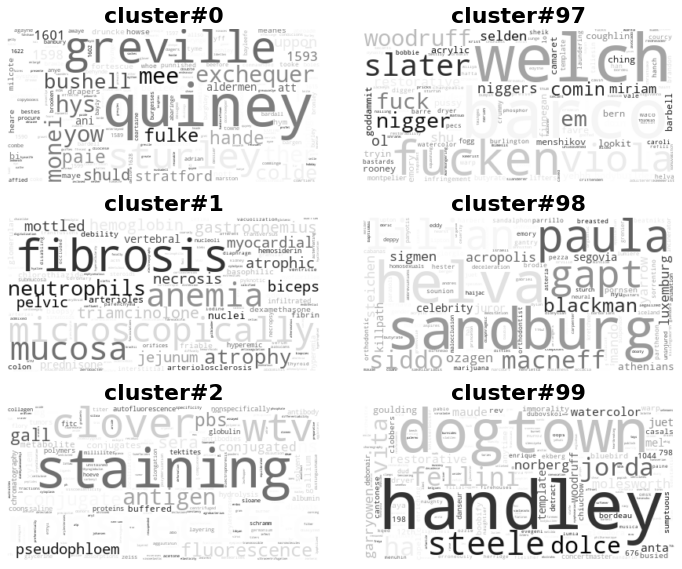

In [27]:
chosen_ix = [0, 97, 1, 98, 2, 99]

fig, axs = plt.subplots(3, 2, figsize=(10, 8))

k = 0
for i in range(len(axs)):
    for j in range(len(axs[i])):
        wc = WordCloud(colormap='Greys', background_color='white')
        im = wc.generate_from_frequencies(cluster_term[clusters[chosen_ix[k]]])
        axs[i][j].imshow(im, interpolation='bilinear')
        axs[i][j].axis("off")
        axs[i][j].set_title(clusters[chosen_ix[k]], **font)
        k += 1
        
plt.tight_layout()
plt.show()

Cluster #2 seems to be related to medical topics. The others don't appear very informative. This makes sense because this is an approximation of the original matrix, not a clustering of the matrix. This does reduce the dimensions, though, so we could still use this for downstream processing.

The idea that our data is composed of some features relating terms to documents can be directly addressed.

## Nonnegative Matrix Factorization

In nonnegative matrix factorization (NMF), we assume that the document-term matrix is the product of two other matrices. The dimension along which these matrices are multiplied will have our clusters. This will give us a document matrix and a term matrix, each with distribution across clusters.

\begin{equation}
X = D \cdot T
\end{equation}

If we have M documents and N terms, and we want K clusters, X is a MxN matrix, D is a MxK matrix, and T is an KxM matrix. In scikit-learn, these matrices are approximated, since there is no closed-form way to calculate these matrices. Let's try an example on some toy data.

In [28]:
from sklearn.decomposition import NMF

We will create our random matrix and then split into two clusters.

In [29]:
np.random.seed(314)
X = np.array(np.random.randint(1, 20, size=21).reshape(7, 3))

m = NMF(n_components=2, init='random', random_state=314)
D = m.fit_transform(X)
T = m.components_
X

array([[ 9, 14, 10],
       [11, 15, 17],
       [ 8,  3,  8],
       [17,  4, 13],
       [ 8,  5,  1],
       [ 5, 14,  9],
       [17, 16, 10]])

Now, the product of the two matrices should approximate the original matrix.

In [30]:
X_hat = np.dot(D, T)
X_hat

array([[ 8.82168512, 13.8817222 , 10.31193979],
       [12.94642621, 16.30109226, 13.58360985],
       [ 8.89151218,  3.59533529,  6.43588552],
       [17.69416104,  4.46299878, 11.78275144],
       [ 5.8818731 ,  3.5849985 ,  4.71678044],
       [ 5.32011204, 14.21139378,  8.44192057],
       [14.75882004, 14.50332786, 13.93210152]])

This looks close, but let's look at the absolute percentage error.

In [31]:
100 * np.abs(X - X_hat) / X

array([[  1.98127639,   0.84484142,   3.11939786],
       [ 17.69478376,   8.67394839,  20.09641264],
       [ 11.14390221,  19.8445095 ,  19.55143095],
       [  4.08330023,  11.57496939,   9.3634505 ],
       [ 26.47658629,  28.30002998, 371.67804413],
       [  6.40224086,   1.50995555,   6.20088253],
       [ 13.1834115 ,   9.35420086,  39.32101525]])

Most of the errors are less than 15%. There are some especially egregious errors, though. As with all these methods, you will need to tune to your needs. There is no one-size-fits-all.

Let's run this on a TF.IDF matrix.

In [32]:
model = NMF(n_components=100, init='nndsvdar', random_state=314)

In [33]:
# This will take a few minutes
D = model.fit_transform(tfidf)
T = model.components_

Now let's get our approximation of the tfidf.

In [34]:
tfidf_hat = np.dot(D, T)

Now we can calculate our absolute percentage error. Since our matrix has zeros, we need to add a fudge factor to avoid division by zero.

In [35]:
abs_pct_error = 100 * np.abs(tfidf - tfidf_hat + 1) / (tfidf + 1)

In [36]:
np.median(np.array(abs_pct_error))

76.86063392892328

This error seems high, but let's see how it clustered the terms together.

In [37]:
cluster_term = pd.DataFrame(
    model.components_.T, 
    index=ix2term, 
    columns=clusters)
cluster_term = np.round(cluster_term, decimals=4)

polynomial_vec = cluster_term.iloc[term2ix['polynomial']]
similarities = cluster_term.apply(
    lambda r: 1-cosine(polynomial_vec, r), axis=1)

In [38]:
similarities.sort_values(ascending=False)[:20]

satisfies         1.0
polynomial        1.0
polynomials       1.0
spanned           1.0
divisible         1.0
differentiable    1.0
subspace          1.0
scalar            1.0
monic             1.0
commutes          1.0
commute           1.0
nilpotent         1.0
decomposes        1.0
algebraically     1.0
algebra           1.0
primes            1.0
integers          1.0
exponential       1.0
expressible       1.0
subspaces         1.0
dtype: float64

It seems that it has successfully grouped similar words together. Now let's look at the word clouds.

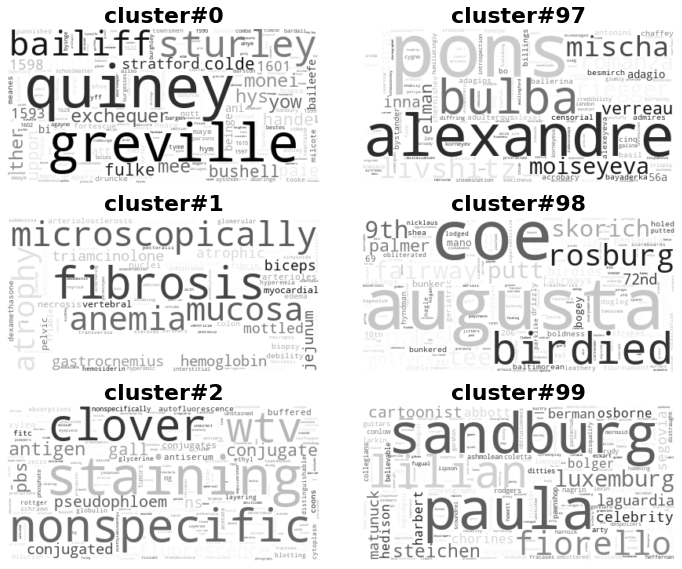

In [39]:
chosen_ix = [0, 97, 1, 98, 2, 99]

fig, axs = plt.subplots(3, 2, figsize=(10, 8))

k = 0
for i in range(len(axs)):
    for j in range(len(axs[i])):
        wc = WordCloud(colormap='Greys', background_color='white')
        im = wc.generate_from_frequencies(
            cluster_term[clusters[chosen_ix[k]]])
        axs[i][j].imshow(im, interpolation='bilinear')
        axs[i][j].axis("off")
        axs[i][j].set_title(clusters[chosen_ix[k]], **font)
        k += 1
        
plt.tight_layout()
plt.show()

It looks like Cluster #1 is related to medical terms and Cluster #97 is related to dance.

All of these techniques ultimately rely on finding transformations related to the space defined by the vocabulary. Let's look at a technique that tries to model the generation of the text.

## Latent Dirichlet Allocation

The idea behind latent Dirichlet allocation (LDA) is that documents are generated based on a set of topics. In this process, we assume that each document is distributed over the topics, and each topic is distributed over the terms. Each document, and each word, are generated from sampling these distributions. The LDA learner works backward and tries to identify the distributions where the observed is most probable.

This is a much more complicated set of assumptions than that of our previous technique. This is because it is trying to model the term-generation process instead of just reducing the dimensions in the vector model.

Let's look at an example.

In [40]:
from sklearn.decomposition import LatentDirichletAllocation

In [41]:
model = LatentDirichletAllocation(
    n_components=K, 
    random_state=314, 
    max_iter=100)

In [42]:
# this can take a few minutes
clustered = model.fit_transform(tfidf)

In [43]:
cluster_term = pd.DataFrame(
    model.components_.T, 
    index=ix2term, 
    columns=clusters)
cluster_term = np.round(cluster_term, decimals=4)


Let's see what words are closest to "polynomial," as we've done for other techniques.

In [44]:
polynomial_vec = cluster_term.iloc[term2ix['polynomial']]

similarities = cluster_term.apply(
    lambda r: 1-cosine(polynomial_vec, r), 
    axis=1)

In [45]:
similarities.sort_values(ascending=False)[:20]

polynomial        1.0
secants           1.0
diagonalizable    1.0
hino              1.0
secant            1.0
nilpotent         1.0
invariant         1.0
congruence        1.0
jastrow           1.0
szold             1.0
commute           1.0
polynomials       1.0
involution        1.0
kayabashi         1.0
subspace          1.0
galaxies          1.0
quadric           1.0
jo                1.0
beckett           1.0
tangents          1.0
dtype: float64

This seems less focused than the results from the other techniques. Let's look at the word clouds.

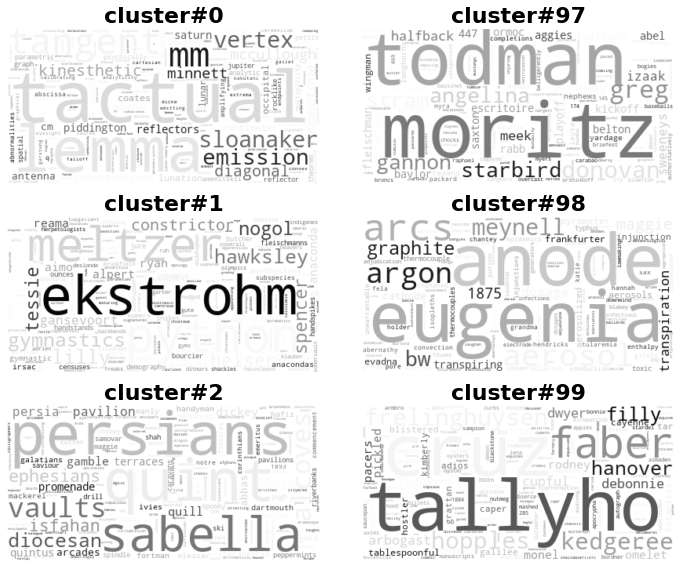

In [46]:
chosen_ix = [0, 97, 1, 98, 2, 99]

fig, axs = plt.subplots(3, 2, figsize=(10, 8))

k = 0
for i in range(len(axs)):
    for j in range(len(axs[i])):
        wc = WordCloud(colormap='Greys', background_color='white')
        im = wc.generate_from_frequencies(
            cluster_term[clusters[chosen_ix[k]]])
        axs[i][j].imshow(im, interpolation='bilinear')
        axs[i][j].axis("off")
        axs[i][j].set_title(clusters[chosen_ix[k]], **font)
        k += 1
        
plt.tight_layout()
plt.show()

These techniques give us ways to cluster documents, reduce the dimensionality of our document vector data, and even group words together. Recently, there has been great progress in distributional semantics using neural networks. In the next chapter, we will cover some of these newer techniques.

## Exercises

Let's see how these techniques work on our classification problem from #information_extraction. We will be using Spark's implementation of LDA for this.

First, let's load the data.

In [47]:
import os
import re

import numpy as np
import pandas as pd

from pyspark.sql.types import *
from pyspark.sql.functions import expr
from pyspark.sql import Row
from pyspark.ml import Pipeline
from pyspark.ml.feature import *
from pyspark.ml.clustering import LDA
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

import sparknlp
from sparknlp import DocumentAssembler, Finisher
from sparknlp.annotator import *

%matplotlib inline

spark = sparknlp.start()

In [48]:
HEADER_PTN = re.compile(r'^[a-zA-Z-]+:.*')

def remove_header(path_text_pair):
    path, text = path_text_pair
    lines = text.split('\n')
    line_iterator = iter(lines)
    while HEADER_PTN.match(next(line_iterator)) is not None:
        pass
    return path, '\n'.join(line_iterator)

In [70]:
path = os.path.join('data', 'mini_newsgroups', '*')
texts = spark.sparkContext.wholeTextFiles(path).map(remove_header)

schema = StructType([
    StructField('path', StringType()),
    StructField('text', StringType()),
])

texts = spark.createDataFrame(texts, schema=schema) \
    .withColumn('newsgroup', expr('split(path, "/")[4]')) \
    .persist()

train, test = texts.randomSplit([0.8, 0.2], seed=123)

In [71]:
texts.limit(5).toPandas()

,path,text,newsgroup
0,file:/content/data/mini_newsgroups/rec.sport.h...,"In article <vzhivov.735059801@cunews>, vzhivov...",rec.sport.hockey
1,file:/content/data/mini_newsgroups/rec.sport.h...,In <1993Apr15.170226.11074@cci632.cci.com> dwk...,rec.sport.hockey
2,file:/content/data/mini_newsgroups/rec.sport.h...,"O.K., only one series is done. But I need to ...",rec.sport.hockey
3,file:/content/data/mini_newsgroups/rec.sport.h...,In article <rauser.734062608@sfu.ca> rauser@fr...,rec.sport.hockey
4,file:/content/data/mini_newsgroups/rec.sport.h...,In article <1993Apr15.161737.28377@sol.UVic.CA...,rec.sport.hockey


Now, let's build our NLP pipeline.

In [72]:
assembler = DocumentAssembler()\
    .setInputCol('text')\
    .setOutputCol('document')
sentence = SentenceDetector() \
    .setInputCols(["document"]) \
    .setOutputCol("sentences")
tokenizer = Tokenizer()\
    .setInputCols(['sentences'])\
    .setOutputCol('token')
lemmatizer = LemmatizerModel.pretrained()\
    .setInputCols(['token'])\
    .setOutputCol('lemma')
normalizer = Normalizer()\
    .setCleanupPatterns([
        '[^a-zA-Z.-]+', 
        '^[^a-zA-Z]+', 
        '[^a-zA-Z]+$',
    ])\
    .setInputCols(['lemma'])\
    .setOutputCol('normalized')\
    .setLowercase(True)
finisher = Finisher()\
    .setInputCols(['normalized'])\
    .setOutputCols(['normalized'])\
    .setOutputAsArray(True)

lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]


Let's remove stop words and use TF.IDF vectors.

In [73]:
stopwords = set(StopWordsRemover.loadDefaultStopWords("english"))

sw_remover = StopWordsRemover() \
    .setInputCol("normalized") \
    .setOutputCol("filtered") \
    .setStopWords(list(stopwords))

count_vectorizer = CountVectorizer(
    inputCol='filtered', outputCol='tf', minDF=10)
idf = IDF(inputCol='tf', outputCol='tfidf')

Spark has an implementation of LDA. Let's use that in combination with logistic regression as our classifier. We will be combining the output of the LDA model with the TF.IDF vectors using the VectorAssembler.

In [74]:
lda = LDA(
    featuresCol='tfidf',
    seed=123,
    maxIter=20,
    k=100,
    topicDistributionCol='topicDistribution',
)

vec_assembler = VectorAssembler(
    inputCols=['tfidf', 'topicDistribution'])

In [75]:
logreg = LogisticRegression(
    featuresCol='topicDistribution',
    maxIter=100,
    regParam=0.0,
    elasticNetParam=0.0,
)

Finally, we assemble our pipeline.

In [76]:
label_indexer = StringIndexer(
    inputCol='newsgroup', outputCol='label')

pipeline = Pipeline().setStages([
    assembler, sentence, tokenizer, 
    lemmatizer, normalizer, finisher,
    sw_remover, count_vectorizer, idf,
    lda, vec_assembler, 
    label_indexer, logreg
])

In [77]:
evaluator = MulticlassClassificationEvaluator(metricName='f1')

In [78]:
model = pipeline.fit(train)

In [79]:
train_predicted = model.transform(train)
test_predicted = model.transform(test)

In [80]:
print('f1', evaluator.evaluate(train_predicted))

f1 0.5632567498946549


In [81]:
print('f1', evaluator.evaluate(test_predicted))

f1 0.42834093131297574


This seems to overfit more than before. Try regularization, and try using only the topics. 

Good luck!